Dataset shape: (12020, 2)


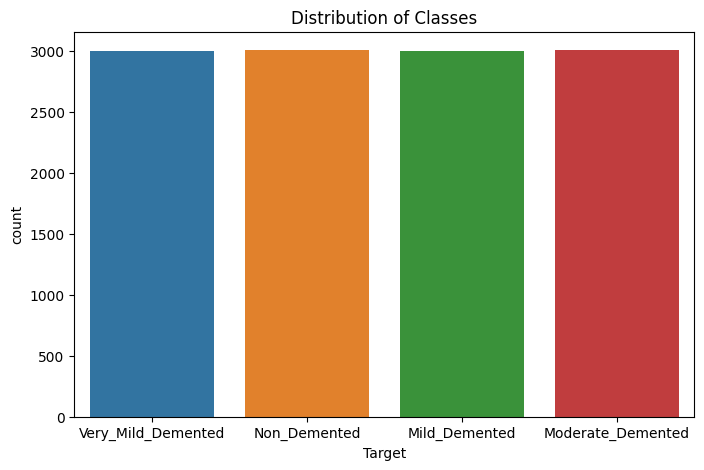

Found 9616 validated image filenames belonging to 4 classes.
Found 2404 validated image filenames belonging to 4 classes.


In [35]:
import os
import glob
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet,VGG16,VGG19, MobileNetV2, ResNet50, ResNet101,ResNet152, InceptionV3,InceptionResNetV2,DenseNet121,DenseNet169,DenseNet201,Xception,NASNetMobile, NASNetLarge
from keras.applications.inception_v3 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix

DATA_PATH = "/kaggle/input/dataset-augmented/AD_AUG"
def load_data(data_path):
    all_paths = glob.glob(f'{data_path}/**/*.*', recursive=True)
    labels = [os.path.split(os.path.split(path)[0])[1] for path in all_paths]
    return pd.DataFrame({'Filepath': all_paths, 'Target': labels}).sample(frac=1).reset_index(drop=True)

dataframe = load_data(DATA_PATH)
def explore_data(df):
    print("Dataset shape:", df.shape)
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x='Target')
    plt.title("Distribution of Classes")
    plt.show()
    dataframe = load_data(DATA_PATH)
explore_data(dataframe)
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocessing: Grayscale,Denoising,CLAHE,Resize,Rescale
#Local Binary Pattern (LBP) for feature extraction

def preprocess_image(filepath):

    image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

    image = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(image)

    image = cv2.resize(image, (128, 128))

    image = image / 255.0

    lbp = local_binary_pattern(image, P=8, R=1, method="uniform")

    return lbp
def prepare_data(df):

    datagen = ImageDataGenerator(validation_split=0.2)

    def custom_image_loader(filepath):
        processed_image = preprocess_image(filepath)
        return np.expand_dims(processed_image, axis=-1)

    train_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='training',
        class_mode='categorical', shuffle=True,
        preprocessing_function=custom_image_loader
    )
    test_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='validation',
        class_mode='categorical', shuffle=False,
        preprocessing_function=custom_image_loader
    )

    return train_data, test_data


train_data, test_data = prepare_data(dataframe)


# **Load Pre-trained ResNet50 and VGG16 Models**

In [58]:
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Load ResNet50 without the top classification layer
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
resnet50_base.trainable = False  # Freeze the base model

# Add custom layers for ResNet50 with regularization
x = resnet50_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 regularization
x = Dropout(0.5)(x)  # Dropout for regularization
resnet50_output = Dense(4, activation='softmax')(x)  # Assuming 4 classes for Alzheimer's disease

# Create the ResNet50 model
resnet50_model = Model(inputs=resnet50_base.input, outputs=resnet50_output)

# Load VGG16 without the top classification layer
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vgg16_base.trainable = False  # Freeze the base model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

# Add Dropout and L2 Regularization to VGG16
x = vgg16_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 Regularization
x = Dropout(0.5)(x)  # Dropout for regularization
vgg16_output = Dense(4, activation='softmax')(x)  # Assuming 4 classes for Alzheimer's disease

# Create the VGG16 model
vgg16_model = Model(inputs=vgg16_base.input, outputs=vgg16_output)

# ** Compile Both Models**

In [59]:
from tensorflow.keras.optimizers import Adam

# Compile ResNet50
resnet50_model.compile(optimizer=Adam(learning_rate=0.00001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

from tensorflow.keras.optimizers import Adam

# Reduce learning rate
vgg16_model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [60]:
from tensorflow.keras.callbacks import EarlyStopping

# Increase patience to 10 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Wait for 10 epochs before stopping
    restore_best_weights=True  # Restore the best weights
)

# ** Train Both Models**

In [61]:
# Train ResNet50
resnet50_history = resnet50_model.fit(
    train_data,
    validation_data=test_data,
    epochs=50,  # Increase epochs since early stopping will handle overfitting
    callbacks=[early_stopping],
    verbose=1
)

# Train VGG16
vgg16_history = vgg16_model.fit(
    train_data,
    validation_data=test_data,
    epochs=50,  # Increase epochs since early stopping will handle overfitting
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - accuracy: 0.3169 - loss: 6.2819 - val_accuracy: 0.6398 - val_loss: 4.8103
Epoch 2/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5073 - loss: 4.9128 - val_accuracy: 0.7051 - val_loss: 4.1766
Epoch 3/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.6179 - loss: 4.1974 - val_accuracy: 0.7512 - val_loss: 3.6855
Epoch 4/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.6678 - loss: 3.7020 - val_accuracy: 0.7762 - val_loss: 3.2905
Epoch 5/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.7090 - loss: 3.3061 - val_accuracy: 0.7887 - val_loss: 2.9714
Epoch 6/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.7282 - loss: 3.0044 - val_accuracy: 0.8174 - val_loss: 2.7009
Epoch 7/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.7597 - loss: 2.7397 - val_accuracy: 0.8295 - val_loss: 2.4831
Epoch 8/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.7756 - loss: 2.5264 - 

# **Combine Predictions Using Averaging**

In [62]:
# Get predictions from ResNet50 and VGG16
resnet50_predictions = resnet50_model.predict(test_data)
vgg16_predictions = vgg16_model.predict(test_data)

# Average the predictions
ensemble_predictions = (resnet50_predictions + vgg16_predictions) / 2

# Convert probabilities to class labels
ensemble_pred_labels = np.argmax(ensemble_predictions, axis=1)

151/151 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


# **Evaluate the Ensemble Model**

Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.87      0.92      0.89       578
 Moderate_Demented       0.93      0.97      0.95       604
      Non_Demented       0.96      0.97      0.96       604
Very_Mild_Demented       0.94      0.84      0.89       618

          accuracy                           0.92      2404
         macro avg       0.92      0.92      0.92      2404
      weighted avg       0.92      0.92      0.92      2404

Confusion Matrix:
[[531  22   6  19]
 [  9 584   0  11]
 [ 14   2 584   4]
 [ 58  21  18 521]]


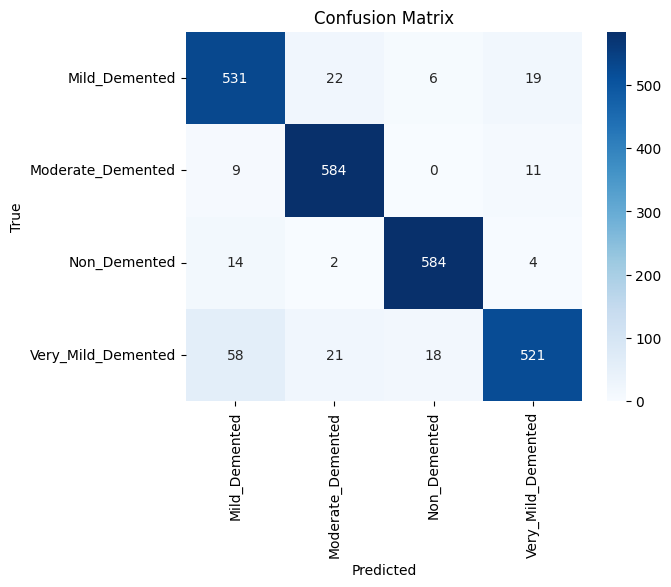

In [63]:
from sklearn.metrics import classification_report, confusion_matrix

# True labels
true_labels = test_data.labels

# Classification report
print("Classification Report:")
print(classification_report(true_labels, ensemble_pred_labels, target_names=test_data.class_indices.keys()))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, ensemble_pred_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

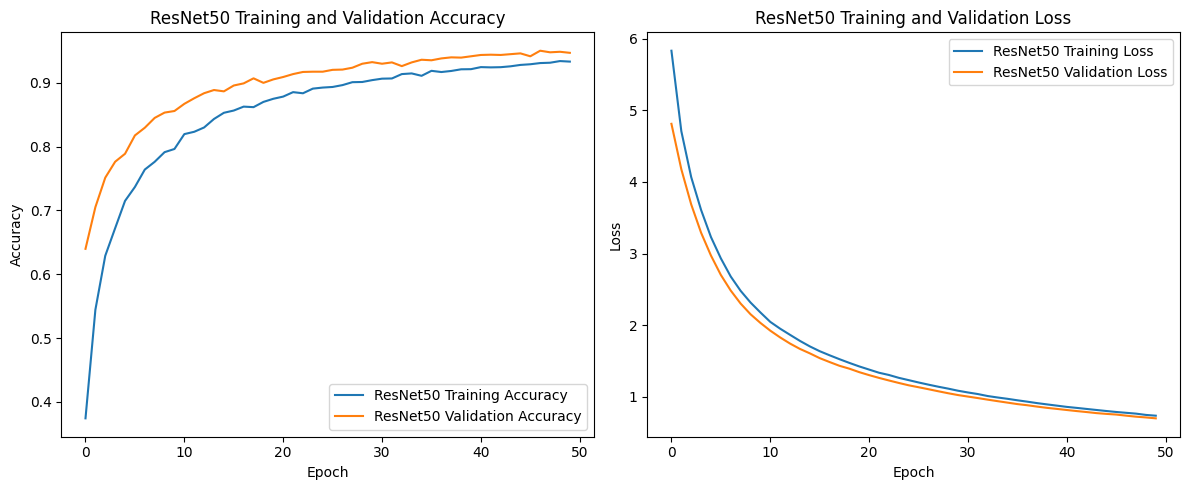

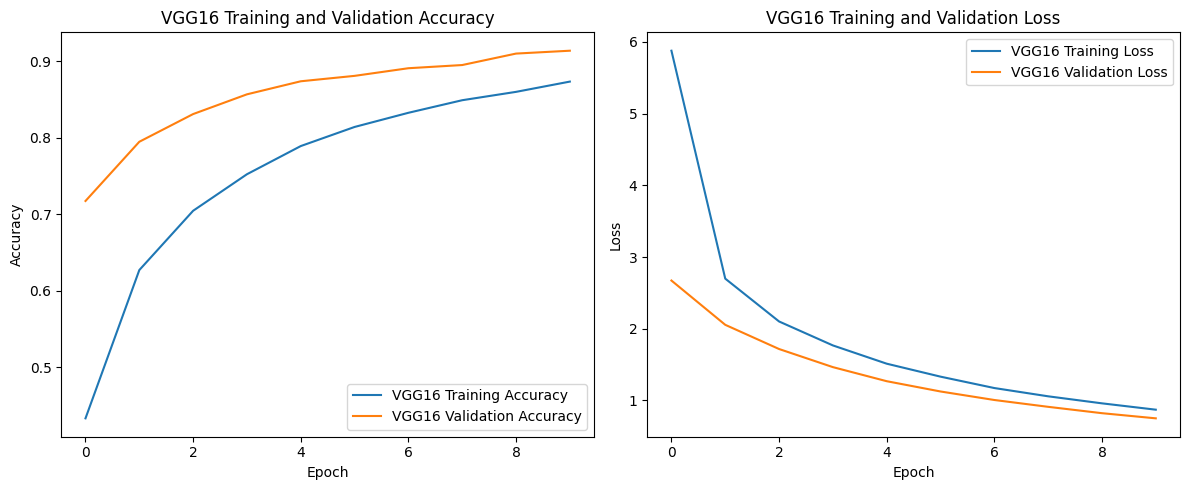

In [64]:
# Plot training & validation accuracy for ResNet50
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(resnet50_history.history['accuracy'], label='ResNet50 Training Accuracy')
plt.plot(resnet50_history.history['val_accuracy'], label='ResNet50 Validation Accuracy')
plt.title('ResNet50 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(resnet50_history.history['loss'], label='ResNet50 Training Loss')
plt.plot(resnet50_history.history['val_loss'], label='ResNet50 Validation Loss')
plt.title('ResNet50 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot training & validation accuracy for VGG16
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(vgg16_history.history['accuracy'], label='VGG16 Training Accuracy')
plt.plot(vgg16_history.history['val_accuracy'], label='VGG16 Validation Accuracy')
plt.title('VGG16 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(vgg16_history.history['loss'], label='VGG16 Training Loss')
plt.plot(vgg16_history.history['val_loss'], label='VGG16 Validation Loss')
plt.title('VGG16 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()